# Rapport de projet de session - IFT 712
### Objectif du projet : tester six méthodes de classification sur une base de données Kaggle.

Nous avons choisi la base de données "[Heart Failure Prediction Dataset][0]" puisqu'elle permet de faire de la classification sur un jeu de données réel et avec des applications concrètes.
Les méthodes de classification que nous allons tester sont les suivantes :
* Modèle génératif
* K plus proches voisins
* Régression logistique
* Méthode à noyaux
* SVM
* Perceptron multicouches

Pour cela, nous utiliserons la bibliothèque scikit-learn pour implémenter les algotihmes ainsi que pandas  pour traiter les données

Nous utiliserons également [Trello][1] ainsi que discord afin d'organiser le projet
Le code est versionné sur [Github][1] en suivant les conventions suivantes :
* conventionals [commits][3]
* merge requests sur master
* une branche par feature (i.e par algorithme de classification)

Le code et les commentaires sont rédigés en francais et suivant la convention [pep8][4]. Nous utiliserons la fonctionnalité "code with me" de pycharm permettant à plussieurs membres du groupe de coder sur le même projet en même temps

[0]: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction
[1]: https://trello.com/b/U21MHLaj/projet-ift712-deadline-11-12-23
[2]: https://github.com/MorganChabaudENSSAT/projet_ift712
[3]: https://www.conventionalcommits.org/en/v1.0.0/
[4]: https://peps.python.org/pep-0008/

In [1]:
'''
 Imporation des bibliothèques python générales
'''
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
import warnings

'''
 Imporation des bibliothèques spécifiques au devoir
'''
from bayes_gaussien_naif import bayes_gaussien_naif
import utils

'''
    Suppression des Futurs Warnings 
'''
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Importation des données
df = pd.read_csv('heart.csv') # Dataframe contenant les données
features_names = df.columns
features_nbr = features_names.shape[0]
print(f"nombre de features dans le dataset : {features_nbr}")
# Visualisation des données pour mieux les comprendre
print(df.head())
print(df.dtypes)

nombre de features dans le dataset : 12
   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  
Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG 

A partir de cette visualisation primaire des données, on  remarque que certaines features sont catégoriques ce qui empêche de les utiliser telles quelles dans les algorithmes de classification.
=> On va donc devoir traiter ces valeurs en les encodant.

In [3]:
le = LabelEncoder()

data = df.copy(deep = True)

data['Sex'] = le.fit_transform(data['Sex'])
data['ChestPainType'] = le.fit_transform(data['ChestPainType'])
data['RestingECG'] = le.fit_transform(data['RestingECG'])
data['ExerciseAngina'] = le.fit_transform(data['ExerciseAngina'])
data['ST_Slope'] = le.fit_transform(data['ST_Slope'])

# Les données sont mainteant toutes numériques et utilisables par les algorithmes de classification que nous mettrons en place
print(data)

     Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
0     40    1              1        140          289          0           1   
1     49    0              2        160          180          0           1   
2     37    1              1        130          283          0           2   
3     48    0              0        138          214          0           1   
4     54    1              2        150          195          0           1   
..   ...  ...            ...        ...          ...        ...         ...   
913   45    1              3        110          264          0           1   
914   68    1              0        144          193          1           1   
915   57    1              0        130          131          0           1   
916   57    0              1        130          236          0           0   
917   38    1              2        138          175          0           1   

     MaxHR  ExerciseAngina  Oldpeak  ST_Slope  Hear

A présent, on explore les données à l'aide de visualisations afin de mieux comprendre leur nature et détecter les features les plus caractéristiques ainsi que la nature des distributions des données afin, au besoin, de formuler des hypothèses nous permettant de mettre en oeuvre différents modèles.
On commence par visualiser la distribution de chaque feature.

C:\Users\carol\AppData\Local\Temp\ipykernel_9156\3787816366.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[cur_feature], kde_kws={'bw' : 1})
C:\Users\carol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\distributions.py:2511: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=1`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
C:\Users\carol\AppData\Local\Temp\ipykern

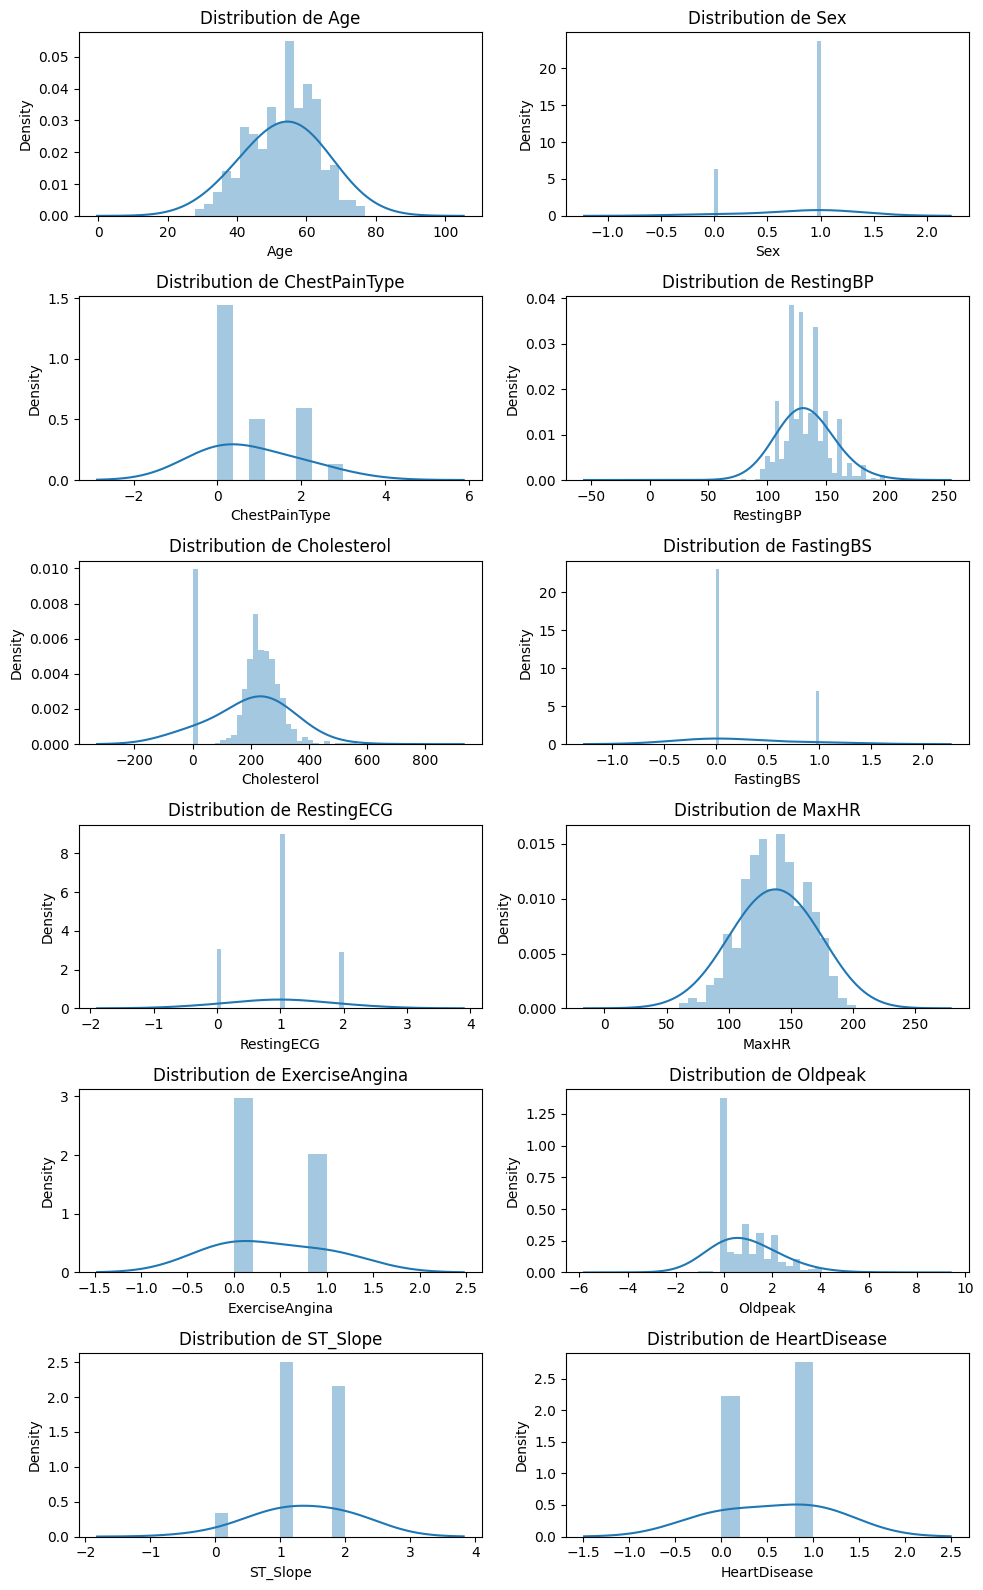

In [4]:
fig = plt.figure(figsize=(10,16))
for i in range(features_nbr):
    plt.subplot(int(features_nbr/2), 2, i+1)
    fig.tight_layout()
    cur_feature =features_names[i]
    sns.distplot(data[cur_feature], kde_kws={'bw' : 1})
    plt.title("Distribution de "+cur_feature)

Les données semblent suivre approximativement une distribution normale dans une majorité de cas. On assumera donc dans la suite du projet, lorsque cela est nécessaire que les données suivent une loi normale.

### Entrainement et évaluation du modèle
La structure de forêt d'arbres étant invariante par changement d'échelle, il n'est pas nécessaire de normaliser les données. En outre, la décision par majorité de votes permet de réduire l'influence des valeurs extremales, ce qui explique que standardiser les données n'est pas requis. Les données sont donc séparées telles quelles pour créer les ensembles d'entrainement et de test.

In [5]:
# Récupération des ensembles d'entraînement et de validation
X_train, X_test, y_train, y_test = forest.split_data(data)

NameError: name 'forest' is not defined

Le modèle est alors entraîné à l'aide de l'ensemble d'entrainement, puis évalué à l'aide de l'ensemble de test.

In [ ]:
# Entraînement du modèle avec l'ensemble d'entraînement
forest.train(X_train, y_train)
# Evaluation du modèle avec l'ensemble de test
forest.evaluate_model(X_test,y_test)

Les résultats obtenus sont présentés sous la forme d'une matrice de confusion, qui permet de visualiser les prédictions correctes et incorrectes du modèle. Le modèle de forêt aléatoire permet donc d'obtenir une précision d'environ 88.04%, avec 39.13% de vrais négatifs et 48.91% de vrais positifs, ce qui présente des résulats similaires aux algorithmes précédents : les vrais négatifs semblent plus difficiles à prédire.

### Recherches d'hyperparamètres optimaux

Les paramètres et hyperparamètres du modèles sont les suivants :

In [ ]:
print(forest.model.get_params())

#### Recherche aléatoire
Dans un premier temps, en vue d'estimer des intervalles à explorer pour les hyperparamètres, une recherche aléatoire est faite. Pour cela, sont parcourus des invervalles linéaires de valeurs pour le nombre d'arbres dans la forêt (n_estimators), la profondeur maximale dans les arbres de décision (max_depth), le minimum d'observations dans un noeud avant de pouvoir le séparer (min_samples_split), le minimum d'observations dans une feuille (min_samples_leaf), ainsi que la méthode de séparation des données (bootstrap).

In [ ]:
best_random_forest_estimator = forest.random_hyper_parameters_search(X_train, y_train)

Ces valeurs permettent d'établir des intervalles réduits pour un parcourt plus précis, cette fois à l'aide d'une grille exhaustive, en vue de la recherche des paramètres optimaux. En effet, une recherche alétoire semble potentiellement moins poerformante.

#### Recherche exhaustive
La recherche des hyperparamètres pour optimiser le modèle de forêt aléatoire est ensuite faite de manière exhaustive de manière plus précise, à l'aide des paramètres trouvés précédemment. Elle explore un espace défini d'hyperparamètres et utilise une validation croisée stratifiée pour évaluer la performance. Les meilleurs hyperparamètres déterminés et la précision associée au modèle optimal sont alors affichés.

In [ ]:
best_random_forest_estimator = forest.random_hyper_parameters_search(X_train, y_train)
best_forest_estimator = forest.hyper_parameters_search(X_train, y_train)
best_forest = foret_aleatoire(data, features_names=features_names, features_nbr=features_nbr, model = best_forest_estimator)
best_forest.evaluate_model(X_test,y_test)

Tel qu'observé, la précision du modèle augmente de manière minime, passant de 88.04% à 89.13%, avec 38.59% de vrais négatifs et 50.54% de vrais positifs. Cela signifie que la recherche d'hyperparamètres optimaux a augmenté la précision en améliorant la prédiction des vrais positifs au détriment de la prédiction des vrais négatifs.

## 6 - Bayes gaussien naïf

Dans cette section, l'algorithme Bayes gaussien naïf repose sur le théorème de Bayes et suppose que les caractéristiques sont conditionnellement indépendantes, étant donné la classe de l'observation. En utilisant une distribution gaussienne pour modéliser les caractéristiques, il calcule la probabilité a posteriori de chaque classe pour une observation donnée, choisissant la classe avec la probabilité la plus élevée comme prédiction.

### Création d'une instance du modèle de forêt aléatoire
Nous commençons par créer une instance de la classe bayes_gaussien_naif, qui hérite des fonctionnalités de la classe abstraite Modele.

In [6]:
seed = 42
np.random.seed(seed)
# Création d'une instance du modèle de Bayes gaussien naïf
gnb = bayes_gaussien_naif(data=data, features_names=features_names, features_nbr=features_nbr, model=GaussianNB())

### Entrainement et évaluation du modèle
La normalisation n'est généralement pas nécessaire pour un Bayes gaussien naïf car cet algorithme est généralement peux affecté par les changements d'échelle. Toutefois, la standardisation pourrait être pertinente, puisqu'elle aide à respecter l'hypothèse de distribution gaussienne en centrant les données autour de zéro et en les mettant à l'échelle par l'écart-type, améliorant ainsi la cohérence des données avec les hypothèses de l'algorithme. Une fois standardisées, les données sont séparées pour créer les ensembles d'entrainement et de test.

In [7]:
# Récupération des ensembles d'entraînement et de validation
standardized_data = gnb.scale_data(features_to_normalise=[], features_to_standardise=features_names[:-1])
X_train, X_test, y_train, y_test = gnb.split_data(standardized_data)
print(standardized_data.head())
print(features_names)

        Age       Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  \
0 -1.433140  0.515952       0.229032   0.410909     0.825070  -0.551341   
1 -0.478484 -1.938163       1.275059   1.491752    -0.171961  -0.551341   
2 -1.751359  0.515952       0.229032  -0.129513     0.770188  -0.551341   
3 -0.584556 -1.938163      -0.816995   0.302825     0.139040  -0.551341   
4  0.051881  0.515952       1.275059   0.951331    -0.034755  -0.551341   

   RestingECG     MaxHR  ExerciseAngina   Oldpeak  ST_Slope  HeartDisease  
0    0.017255  1.382928       -0.823556 -0.832432  1.052114             0  
1    0.017255  0.754157       -0.823556  0.105664 -0.596078             1  
2    1.601219 -1.525138       -0.823556 -0.832432  1.052114             0  
3    0.017255 -1.132156        1.214246  0.574711 -0.596078             1  
4    0.017255 -0.581981       -0.823556 -0.832432  1.052114             0  
Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'Restin

Le modèle est alors entraîné à l'aide de l'ensemble d'entrainement, puis évalué à l'aide de l'ensemble de test.

Précision du modèle : 0.8369565217391305


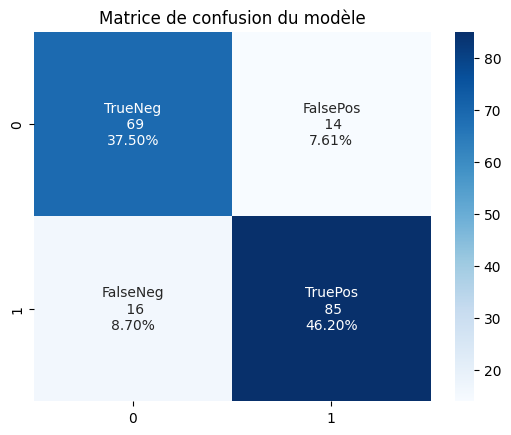

In [8]:
# Entraînement du modèle avec l'ensemble d'entraînement
gnb.train(X_train, y_train)
# Evaluation du modèle avec l'ensemble de test
gnb.evaluate_model(X_test,y_test)

Les résultats obtenus sont également présentés sous la forme d'une matrice de confusion, qui permet de visualiser les prédictions correctes et incorrectes du modèle. L'algorithme de Bayes gaussien naïf permet donc d'obtenir une précision d'environ 83.70%, avec 37.50% de vrais négatifs et 46.20% de vrais positifs, ce qui présente également des résulats similaires aux algorithmes précédents : les vrais négatifs semblent légèrement plus difficiles à prédire.

### Recherches d'hyperparamètres optimaux

Les paramètres et hyperparamètres du modèles sont les suivants :

In [9]:
print(gnb.model.get_params())

{'priors': None, 'var_smoothing': 1e-09}


Le paramètre 'priors' concerne les cas d'utilisation où des connaissances a priori sur la distribution des classes sont disponibles, ce qui n'est pas le cas présent. La recherche d'hyperparamètres ne concerne donc que l'hyperparamètre 'var_smoothing' ici, qui contrôle la régularisation en ajoutant une certaine quantité à la variance des variables. Cela qui permet d'éviter des problèmes de calcul de probabilités conditionnelles lorsque certaines variances sont très proches de zéro. La valeur de var_smoothing devant être faible, un intervalle logarithmique entre 1e-9 et 1 est parcouru.

La meilleure précision trouvée est de 0.85578231292517 pour les hyperparamètres suivants : {'var_smoothing': 0.15199110829529336}
Précision du modèle : 0.842391304347826


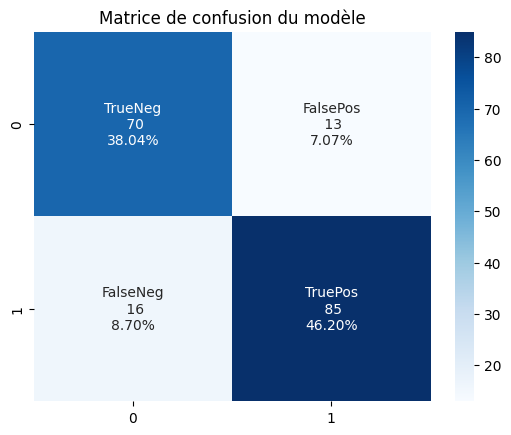

In [10]:
best_gnb_estimator = gnb.hyper_parameters_search(X_train, y_train, seed)
best_gnb = bayes_gaussien_naif(data, features_names=features_names, features_nbr=features_nbr, model=best_gnb_estimator)
best_gnb.evaluate_model(X_test, y_test)

Tel qu'observé, la précision du modèle augmente de manière minime, passant de 83.70% à 84.24%, avec 38.04% de vrais négatifs et 46.20% de vrais positifs. La recherche d'hyperparamètres optimaux pour l'algorithme Bayes gaussien naïf a donc amélioré la prédiction des vrais négatifs, contrairement au cas de la structure de forêt d'arbres par exemple. Toutefois, elle présente une précision moindre.